# Quick Introduction

The set of notebooks in this folder introduce you to the basic functionalities of `expsolve` for solving PDEs using Fourier spatial discretization. We will import

* `expsolve` as `es`

* `expsolve.discretize.tensorgrid` as `ex` (Fourier and finite difference spatial discretizations on equispaced tensorized grids)

The convention across all notebooks is to use `ex` for the spatial discretization (unless more than one spatial discretization is being considered). Doing so allows us to quickly change spatial discretisation. The examples considered in this folder are

* The linear time-dependent Schrödinger equation (TDSE) in 1D, 2D and 3D.

The notebooks in this folder are:

* [00_quick_introduction.ipynb](00_quick_introduction.ipynb). This notebook.
* [01_grid.ipynb](01_grid.ipynb). 1D, 2D, 3D grids (`grid1d`, `grid`), discretizing and visualizing a function (`plot`, `imshow`).
* [02_differentiation.ipynb](02_differentiation.ipynb). Fourier and finite difference differentiation matrices and operators (`diffop`, `diffmatrix`, `matmul`).
* [03_observables.ipynb](03_observables.ipynb). $L^2$ norm and inner product (`l2norm`, `l2inner`, `normalize`), other observables - energy, momentum, position (`observable`, `matmul`).
* [04_brute_force_solution_of_schrodinger.ipynb](04_brute_force_solution_of_schrodinger.ipynb). Solving TDSE by exponentiating Hamiltonian 1D and 2D (`diag`, `matrix_exp`, `matmul`).
* [05_split_step_method_for_schrodinger.ipynb](05_split_step_method_for_schrodinger.ipynb). Solving TDSE using splittings and Fourier in 1D, 2D and 3D (`diffopexp`, `laplaciansymbol`, `laplacianopexp`).

This notebook is a quick start guide for 1D Schrödinger equation.

*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [3]:
import time 

import numpy as np

import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex

import torch
from torch import exp, kron, eye, sin, cos, abs, real, imag, pi, max, diag
from torch.linalg import norm, matrix_exp

Creating a grid (`grid1d`)

In [4]:
n = 200
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr)

Initial conditons (`normalize`, `plot`)

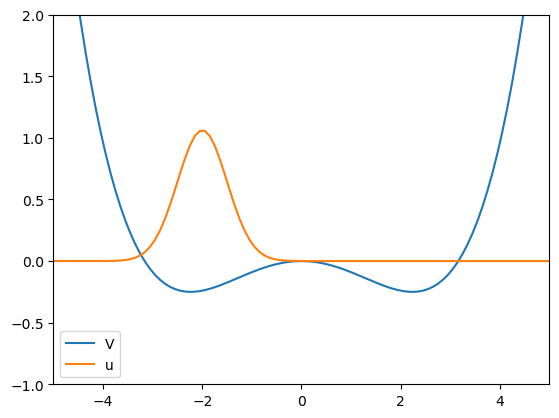

In [9]:
x0 = -2.0
u = exp(-(x-x0)**2/(2*0.25))
u = ex.normalize(u, xr)    

V = x**4 - 10*x**2

ex.plot(plt, x, V/100)
ex.plot(plt, x, real(u))
plt.xlim(-5,5)
plt.ylim(-1,2)
plt.legend(['V','u'])
plt.show()

Computing derivatives (`diffop`)

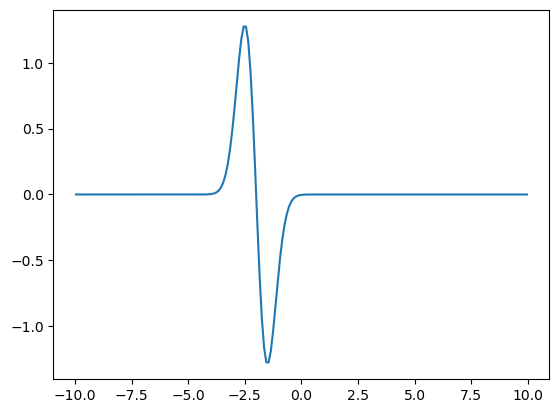

In [11]:
ex.plot(plt, x, ex.diffop(0,1,real(u),xr))
plt.show()

Implementing a single step of Strang splitting (`diffopexp`)

In [12]:
eLu = lambda h, u: ex.diffopexp(0, 2, 1j*h, u, xr)
eVu = lambda h, u: exp(-1j*h*V)*u
strang = lambda h, u: eVu(h/2, eLu(h, eVu(h/2, u)))

Observables

In [13]:
obs = {'energy': lambda psi: -ex.diffop(0, 2, psi, xr) + V*psi, 
'position': lambda psi: x*psi,
'momentum': lambda psi: 1j*ex.diffop(0, 1, psi, xr),
'kinetic': lambda psi: -ex.diffop(0, 2, psi, xr),
'potential':lambda psi: V*psi}

Code for computing observables

In [14]:
T = 1

Ndt = 1000
timegrid = torch.linspace(0, T, Ndt+1)

obsvalues = {}
for o in obs:
    obsvalues[o] = torch.zeros((len(timegrid), 1), dtype=torch.float64)

def compute_obs_values(u, n):
    for o in obs:
        obsfn = obs[o]
        obsvalues[o][n] = ex.observable(obsfn, u, xr)    # not the most general for batch parallelized

Computing solution and observables

In [15]:
compute_obs_values(u, 0)
def runstrang(T, N, u0):
    u = u0
    h = T/N
    for i in range(N):
        u = strang(h, u)
        compute_obs_values(u, i+1)
    return u

ustrangT = runstrang(T, Ndt, u)

for o in obs:
    obsvalues[o] = obsvalues[o].T

Final solution

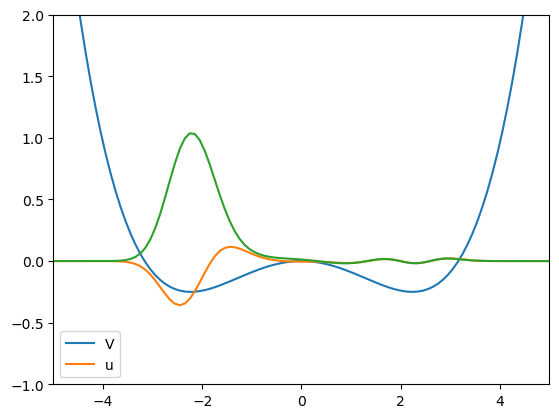

In [17]:
ex.plot(plt, x, V/100)
ex.plot(plt, x, real(ustrangT))
ex.plot(plt, x, imag(ustrangT))
plt.xlim(-5,5)
plt.ylim(-1,2)
plt.legend(['V','u'])
plt.show()

Plotting observables (`obsplot`)

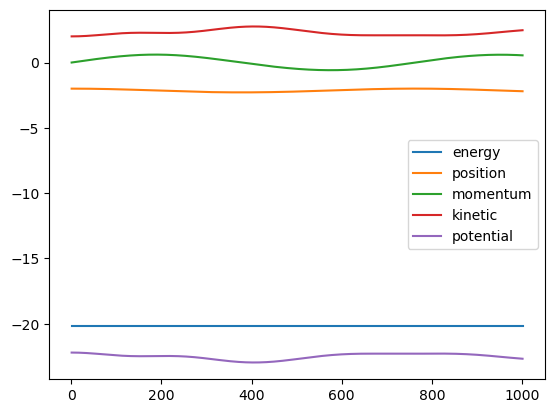

In [18]:
ex.obsplot(plt, obsvalues)